In [4]:
import glob
import xarray as xr
import numpy as np
import cmocean
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import path, colors
import skimage.io as io
from scipy import stats
import pandas as pd
from datetime import datetime, timedelta

In [5]:
from caribbean_map import *
from beachings import *

In [6]:
ds = xr.open_dataset('../data/output/cm_uniform/cm_uniform_2013-01-01.nc')  # same date as the mpw
lon = ds.lon.values
lat = ds.lat.values
nb_traj, nb_obs = lon.shape
origin_date = datetime(2013,1,1)

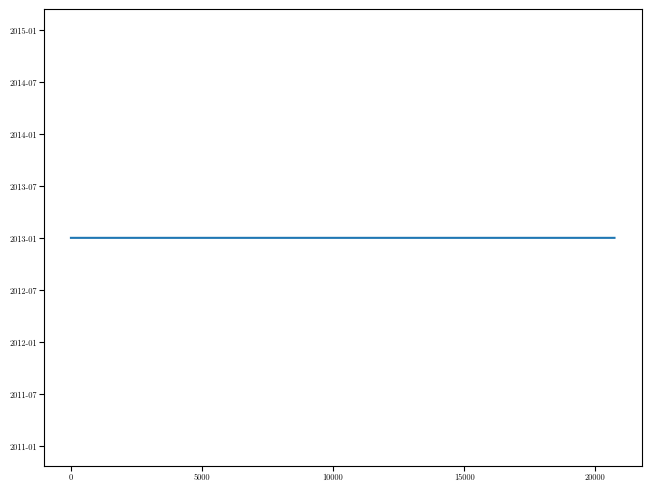

In [21]:
plt.plot(xr.open_dataset('../data/output/cm_uniform/cm_uniform_2013-01-01.nc').time[:,0])

In [7]:
# distance at each timestep for each trajectory
d = haversine(lon, lat)

In [9]:
threshold_distance = 100*1000 # [m]
period = 30 # [days]
beached_days = 90  # [days]

b_idx = np.zeros(nb_traj, dtype=int)
for i in range(0, nb_traj):
    b_idx[i] = identify_beaching_c1(d[i], threshold_distance, period)

In [10]:
def trajectories(ax, t0, length):
    # smaller length at initial time
    if length > t0:
        length = t0
    
    time_r = range(t0-length, t0+1)
    keep = np.any(~np.isnan(lon[:, time_r]), 1)
    traj = list(zip(lon[keep][:,time_r], lat[keep][:,time_r]))
    
    s, v = [], []
    for x,y in traj:
        pts = np.array([x, y]).T.reshape(-1, 1, 2)
        s.extend(np.concatenate([pts[:-1], pts[1:]], axis=1))
        v.extend(np.arange(0, len(x))/len(x))
    
    v = np.array(v).flatten()
    
    lc = LineCollection(s, cmap=cmocean.cm.ice_r, transform=ccrs.PlateCarree(), alpha=1.0)
    lc.set_array(v) # color per segments/lines
    lc.set_linewidth(0.25) # size of lines
    ax.add_collection(lc)
    
    # add tip
    ax.scatter(lon[keep][:,t0], lat[keep][:,t0], s=0.2, linewidth=0.5, c='k', marker='o', facecolors='fill', zorder=2)
    
    # add red tip if beached
    beached = np.logical_and.reduce((b_idx > -99999, b_idx < t0, b_idx+beached_days >= t0, keep))
    ax.scatter(lon[beached][:,t0], lat[beached][:,t0], s=0.1, linewidth=0.5, c='r', marker='o', facecolors='fill', zorder=2)
    
    return s, v

CPU times: user 8.78 s, sys: 460 ms, total: 9.24 s
Wall time: 9.31 s


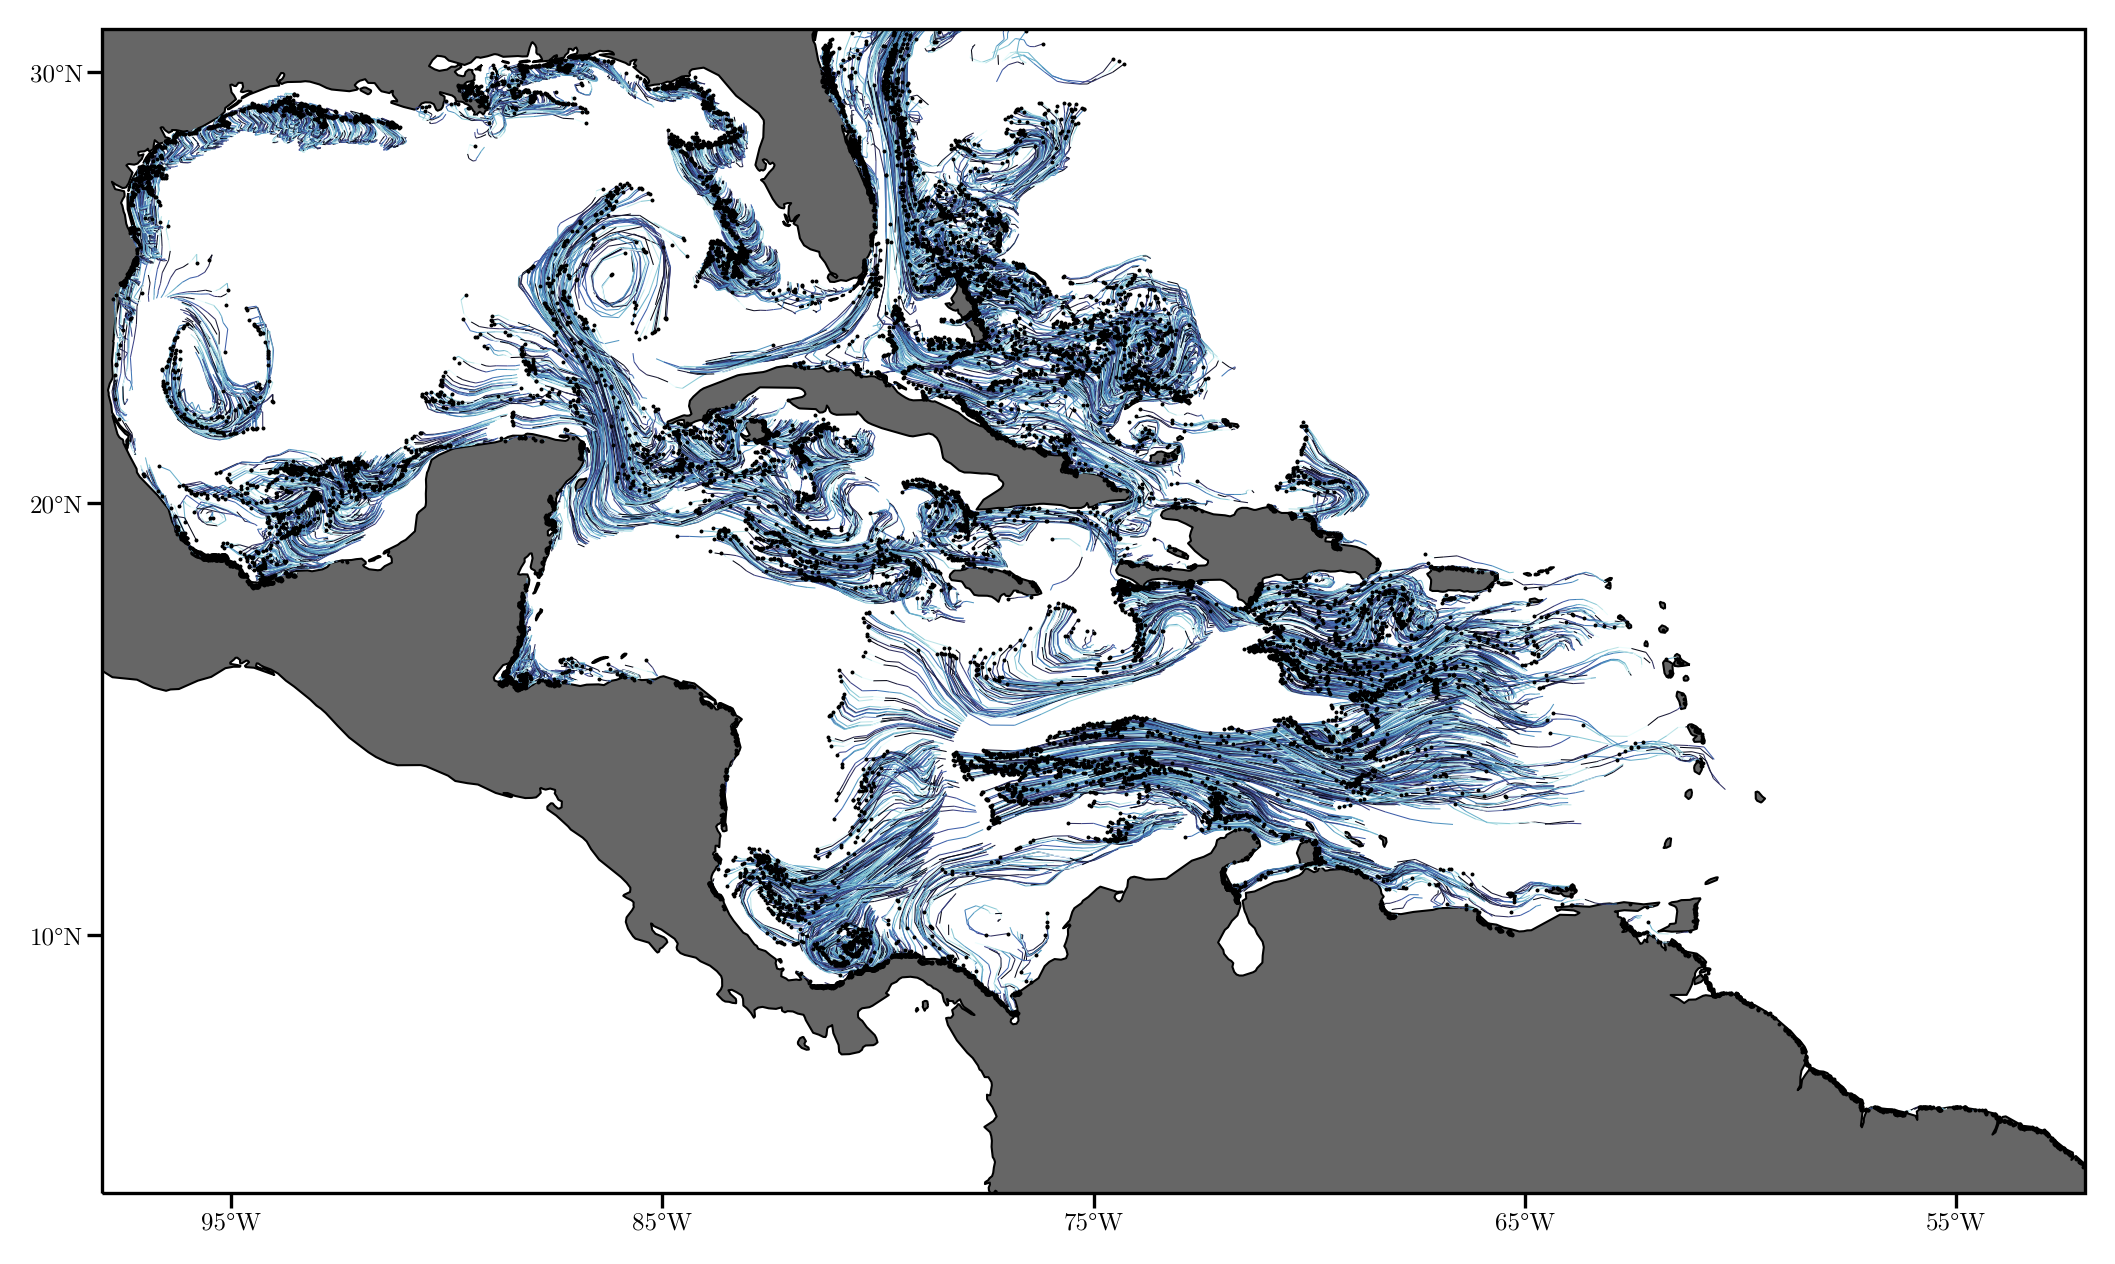

In [12]:
%%time
fig = plt.figure(dpi=300, figsize=fs)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(), aspect='equal')

t0 = 50
traj_length = 10  # index/days because daily output
s, v = trajectories(ax, t0, traj_length)

geo_map(ax)
#ax.set_title(f"Nested Caribbean model {(origin_date+timedelta(days=t0)).strftime('(%Y-%m-%d)')}")
fig.savefig(f'figures/cm_uniform_{t0:04d}.png', format='png', dpi=600)